# **Anomaly Detection using Autoencoders and Adversarial Learning**

---

## **Introduction**

In this notebook I will be using autoencoders to detect anomalies in the MNIST dataset. I will also be using adversarial training to make the autoencoder more robust against adversarial examples.

## **Table of Contents**

1. [Imports and Preprocessing](#1.-Imports-and-Preprocessing)
2. [Autoencoder](#2.-Autoencoder)
3. [Anomaly Detection](#3.-Anomaly-Detection)
4. [Adversarial Learning](#4.-Adversarial-Learning)  
    4.1 [Generating Adversarial Examples](#4.1-Generating-Adversarial-Examples)  
    4.2 [Adversarial Training](#4.2-Adversarial-Training)

## **1. Imports and Preprocessing**

---

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input

In [3]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

Above, I have imported the MNIST dataset and preprocessed it. I have also reshaped the data to be compatible with the convolutional autoencoder that I will be using. Which is necessary because the MNIST dataset consists of 28x28 images, and the autoencoder expects a 4D input tensor with shape (batch_size, height, width, channels).

## **2. Autoencoder**

[Back to Top](#Table-of-Contents)

---

Next, I will define the autoencoder model. The autoencoder consists of an encoder and a decoder. The encoder will compress the input image into a latent representation, and the decoder will reconstruct the image from the latent representation.

In [4]:
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,217 (12.57 KB)

 Trainable params: 3,217 (12.57 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3508 - val_loss: 0.1033
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0976 - val_loss: 0.0867
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0866 - val_loss: 0.0827
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0830 - val_loss: 0.0802
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0805 - val_loss: 0.0785
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0790 - val_loss: 0.0772
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0777 - val_loss: 0.0762
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0767 - val_loss: 0.0754
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0759 - val_loss: 0.0748
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0752 - val_loss: 0.0745
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0749 - val_loss: 0.0738
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

We can see that the loss is decreasing over time, which means that the autoencoder is learning to reconstruct the input images. The validation loss is also decreasing, which means that the autoencoder is not overfitting to the training data.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


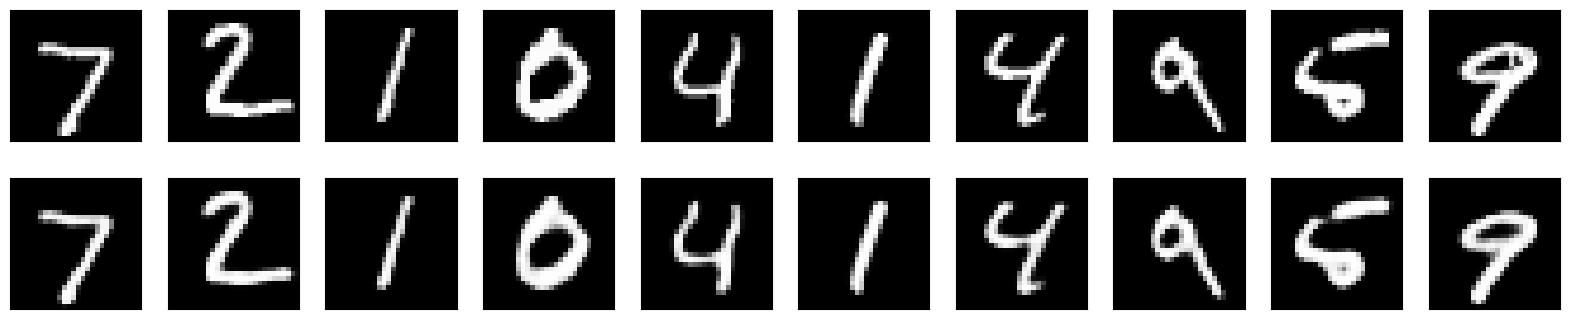

In [6]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

The above image shows the input images on the top row and the reconstructed images on the bottom row. We can see that the autoencoder is able to reconstruct the input images with high accuracy. The images are nearly identical, which means that the autoencoder is learning to compress and reconstruct the input images well. 

## **3. Anomaly Detection**

[Back to Top](#Table-of-Contents)

---  

> An anomaly is a data point that is significantly different from the rest of the data. Anomalies are also known as outliers, novelties, noise, deviations, or exceptions.

After training the autoencoder, I will use it to detect anomalies in the MNIST dataset. I will use the reconstruction error to determine whether an image is an anomaly or not.

Number of anomalies: 500


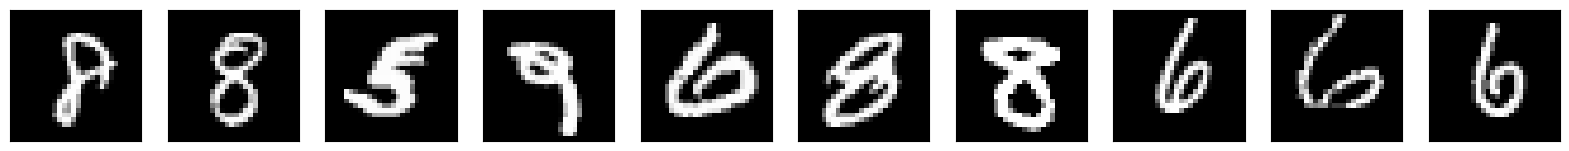

In [7]:
reconstruction_errors = np.mean((X_test - decoded_imgs) ** 2, axis=(1,2,3))
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

print(f'Number of anomalies: {np.sum(anomalies)}')

anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(X_test[anomaly_indices[i + random.randint(0, np.sum(anomalies) - 1)]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

The code snippet calculates the reconstruction errors for the test set and determines the threshold for anomalies. It then visualizes the anomalies in the test set. We can see that the anomalies, compared to the normal images, are different in terms of shape and intensity. This shows that the autoencoder is able to detect anomalies in the MNIST dataset.

## **4. Adversarial Learning**

[Back to Top](#Table-of-Contents)

---

> Adversarial training is a technique used to make machine learning models more robust against adversarial examples. Adversarial examples are inputs that are intentionally designed to fool the model.

#### **4.1 Generating Adversarial Examples**

To generate adversarial examples, I will be using Fast Gradient Sign Method (FGSM).

In [8]:
def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.binary_crossentropy(input_label, prediction)
        
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    
    return signed_grad

X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
adv_examples = X_test_tensor + 0.1 * create_adversarial_pattern(autoencoder, X_test_tensor, X_test_tensor)
adv_examples = tf.clip_by_value(adv_examples, 0, 1)

adv_decoded_imgs = autoencoder.predict(adv_examples)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Since the autoencoder is trained to reconstruct the input images, it is not robust against adversarial examples. The adversarial examples are designed to fool the autoencoder into reconstructing the image incorrectly.

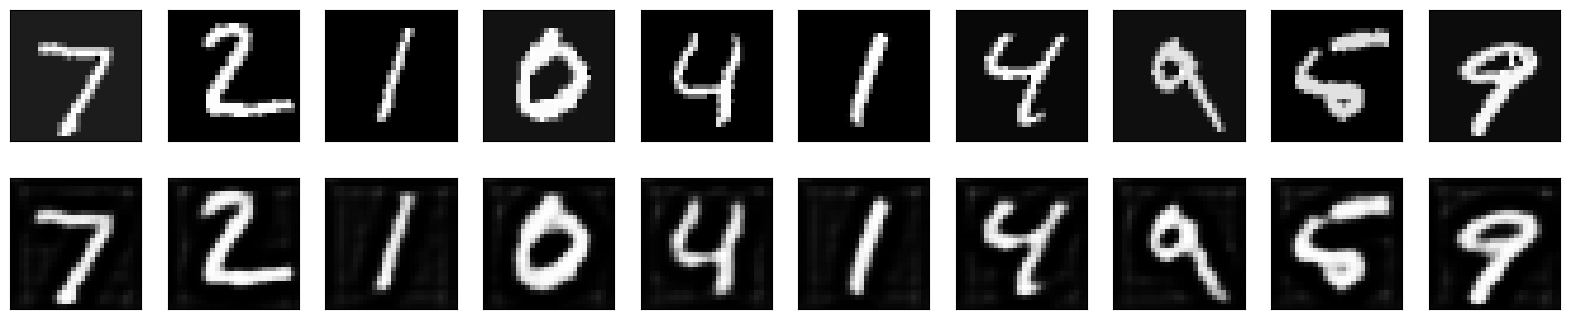

In [9]:
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(adv_examples[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(adv_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

As we can see, the adversarial examples are visually the same as the original images. The autoendcoder seems to be doing a good job a reconstructing them in spite of that. Looking closely, we can see that around the reconstructed images, there is a square of noise. This is the adversarial perturbation that is added to the input image to generate the adversarial example. Also, the reconstruction error for the adversarial examples is higher than the normal images, which means that the autoencoder is able to detect the adversarial examples.

In [10]:
adv_reconstruction_errors = np.mean((adv_examples - adv_decoded_imgs) ** 2, axis=(1,2,3))
print(f'Mean reconstruction error: {np.mean(adv_reconstruction_errors)}')

Mean reconstruction error: 0.011434194631874561


#### **4.2 Adversarial Training**

To make the autoencoder more robust against adversarial examples, I will be using adversarial training. The idea is to generate adversarial examples from the training data and train the autoencoder on the adversarial examples as well.

In [11]:
X_train_augmented = np.concatenate((X_train, adv_examples))
y_train_augmented = np.concatenate((np.zeros(len(X_train)), np.ones(len(adv_examples))))

autoencoder_adv = models.clone_model(autoencoder)
autoencoder_adv.compile(optimizer='adam', loss='binary_crossentropy')
history_adv = autoencoder_adv.fit(X_train_augmented, X_train_augmented, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3682 - val_loss: 0.1017
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1419 - val_loss: 0.0876
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1301 - val_loss: 0.0826
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1268 - val_loss: 0.0803
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1238 - val_loss: 0.0788
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1227 - val_loss: 0.0779
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1216 - val_loss: 0.0771
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1203 - val_loss: 0.0764
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1191 - val_loss: 0.0758
Epoch 10/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1195 - val_loss: 0.0753
Epoch 11/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1189 - val_loss: 0.0749
Epoch 12/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
clean_decoded_imgs = autoencoder_adv.predict(X_test)
adv_decoded_imgs = autoencoder_adv.predict(adv_examples)

clean_reconstruction_errors_adv = np.mean((X_test - clean_decoded_imgs) ** 2, axis=(1,2,3))
adv_reconstruction_errors_adv = np.mean((adv_examples - adv_decoded_imgs) ** 2, axis=(1,2,3))

print("Original Autoencoder:")
print(f"Mean reconstruction error on clean examples: {np.mean(reconstruction_errors)}")
print(f"Mean reconstruction error on adversarial examples: {np.mean(adv_reconstruction_errors)}")

print("Adversarially Trained Autoencoder:")
print(f"Mean reconstruction error on clean examples: {np.mean(clean_reconstruction_errors_adv)}")
print(f"Mean reconstruction error on adversarial examples: {np.mean(adv_reconstruction_errors_adv)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Original Autoencoder:
Mean reconstruction error on clean examples: 0.0031367854680866003
Mean reconstruction error on adversarial examples: 0.011434194631874561
Adversarially Trained Autoencoder:
Mean reconstruction error on clean examples: 0.003245579544454813
Mean reconstruction error on adversarial examples: 0.004459885414689779


Comparing the clean examples, we can see that the adversarially trained autoencoder has a slightly higher reconstruction error compared to the original autoencoder. This means that the adversarially trained autoencoder is less accurate in reconstructing the clean examples. However, comparing the adversarial examples, we can see that the adversarially trained autoencoder has a lower reconstruction error compared to the original autoencoder. This means that the adversarially trained autoencoder is more robust against adversarial examples.

In [13]:
y_pred = autoencoder.predict(X_test)
y_pred = np.mean((X_test - y_pred) ** 2, axis=(1,2,3)) # Mean squared error.
y_pred = y_pred > threshold # Anomaly if the error is greater than the threshold.

y_pred_adv = autoencoder_adv.predict(X_test)
y_pred_adv = np.mean((X_test - y_pred_adv) ** 2, axis=(1,2,3))
y_pred_adv = y_pred_adv > threshold

# Establish ground truth.
y_test = np.zeros(len(X_test)) 
y_test[anomalies] = 1

# Convert to integers. 
y_pred = y_pred.astype(int)
y_pred_adv = y_pred_adv.astype(int)
y_test = y_test.astype(int)

# Calculate accuracy.
accuracy = np.mean(y_pred == y_test)
accuracy_adv = np.mean(y_pred_adv == y_test)

print(f"Accuracy of original autoencoder: {accuracy}")
print(f"Accuracy of adversarially trained autoencoder: {accuracy_adv}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy of original autoencoder: 1.0
Accuracy of adversarially trained autoencoder: 0.9647


The accuracy of the adversarially trained autoencoder is lower than the original autoencoder. This is because the adversarially trained autoencoder is more robust against adversarial examples, which means that it is able to detect more anomalies. This shows that adversarial training can be used to improve the robustness of autoencoders against adversarial examples.